# What are p-values? - a computational approach

This is a simple notebook restating arguments from https://f1000research.com/articles/4-621/v3


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, t
sns.set()

# Definition

A p-value is the probability of observing a result at least as extreme
as a test statistic (e.g., t value), assuming the null hypothesis of no
effect is true.

<ipython-input-17-9fc859b42394>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1)


<Figure size 640x480 with 0 Axes>

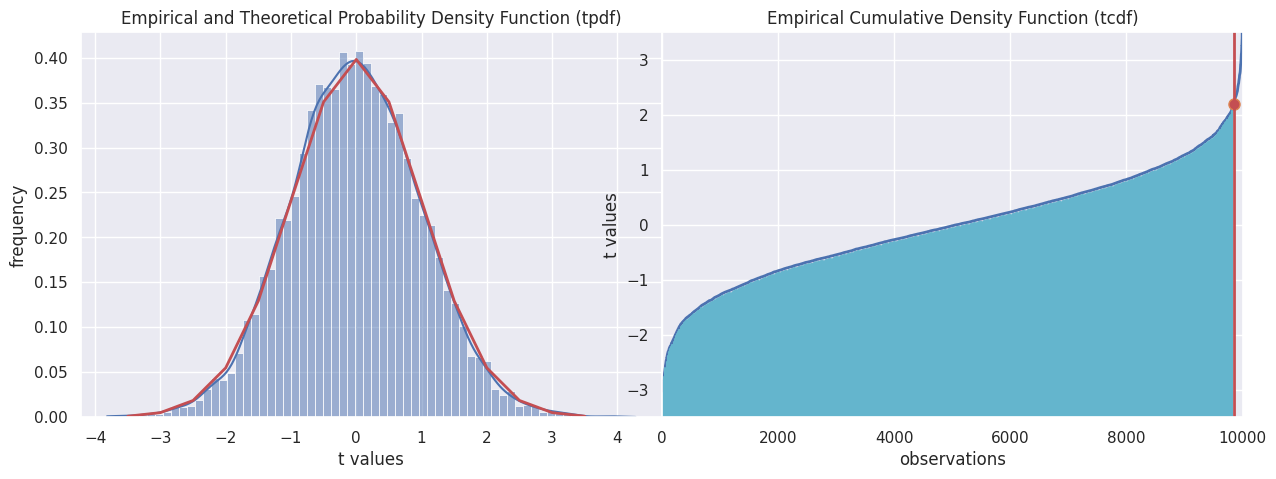

In [17]:
# consider two variables X and Y, and the t statistic associated with their difference
X = np.random.randn(100) + 0.25  # expected mean 0.25
Y = np.random.randn(100)         # expected mean 0

t_stat, pvalue_from_test = ttest_ind(X, Y)

num_perm = 10000;
# set up a bootstrap under the null, i.e. no difference
Xb = X - np.mean(X)  # mean is 0
Yb = Y - np.mean(Y)  # mean is 0
resamples = np.random.choice(100, size=(100, num_perm ))  # make 10000 resamples with replacement
statsb, pnull = ttest_ind(Xb[resamples], Yb[resamples])  # compute 10000 t-tests

# the probability distribution of t values under the null for df = 99 is
plt.figure('t distribution')
plt.subplots(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
sns.histplot(statsb, kde=True, stat="density")
plt.grid(True)
plt.plot(np.arange(-3.5, 4, 0.5), t.pdf(np.arange(-3.5, 4, 0.5), 99), linewidth=2, color='r')
plt.title('Empirical and Theoretical Probability Density Function (tpdf)')
plt.xlabel('t values')
plt.ylabel('frequency')

# a p-value is the probability of observing t or bigger given the cumulative
# probability function of t values under the null, i.e. sort t-values and
# count how many are 'above' observed t
sorted_values = np.sort(statsb)
ax2 = plt.subplot(1, 2, 2)
plt.plot(sorted_values, linewidth=2)
plt.grid(True)
position = np.argmin(np.abs(sorted_values - t_stat))
plt.plot(position + 1, t_stat, 'o', markersize=8, markerfacecolor='r')
plt.axvline(position, color='r', linestyle='-', linewidth=2, label='Count up to here')
plt.title('Empirical Cumulative Density Function (tcdf)')
plt.xlabel('observations')
plt.ylabel('t values')
plt.xlim([-1, num_perm + 10])
plt.ylim([-3.5, 3.5])
for x in range(0, position - 10, 20):
    plt.plot([x, x], [-3.5, sorted_values[x] - 0.05], '-c')

# Remove the overlapping axes warning
plt.subplots_adjust(wspace=0)

# Explicitly remove ax1
plt.show()

In [18]:
pvalue_from_boot = np.sum(sorted_values > t_stat) / num_perm
pvalue_from_boot = 2 * min(1 - pvalue_from_boot, pvalue_from_boot)

# note that if one knows or expects the observed t value to be bigger than
# or smaller than, this is a one-sided t-test and thus the p-value from the
# bootstrap is sum(sorted_values > t_stat) / 10000 or
# sum(sorted_values < t_stat) / 10000
# since we did not specify, it is a two-sided t-test, testing simultaneously if bigger or smaller,
# hence the multiplication by 2

print(f"Theoretical p-value: {pvalue_from_test}, Empirical p-value: {pvalue_from_boot}")

Theoretical p-value: 0.029312251241886272, Empirical p-value: 0.0302


# Misconception

The p-value is not an indication of the strength or magnitude of an effect, because while p-values are randomly distributed when there is no effect, their distribution depends on both the population effect size and the number of participants, making it impossible to infer the strength of effect from them.

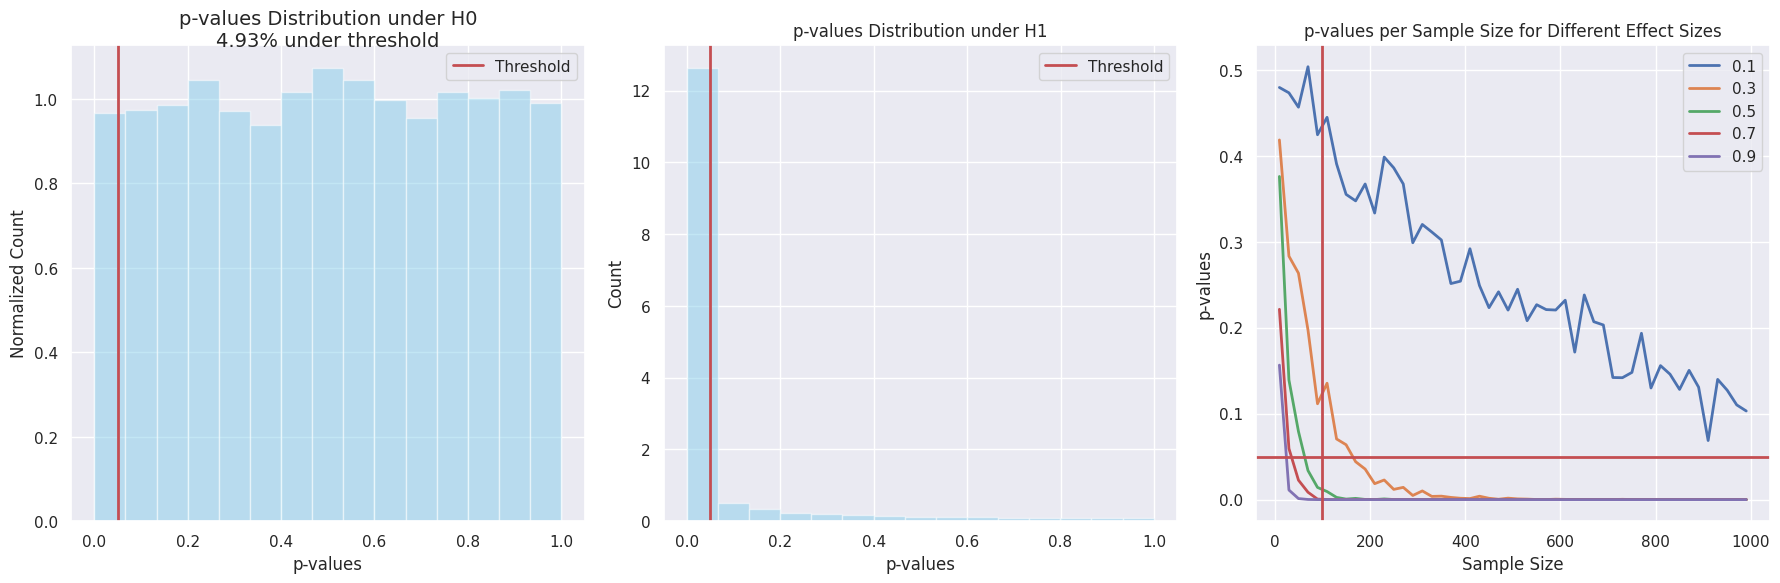

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].hist(pnull.flatten(), density=True, alpha=0.5, bins=15, color='skyblue')
axs[0].axvline(0.05, color='r', linestyle='-', linewidth=2, label='Threshold')
axs[0].set_title('p-values Distribution under H0\n'+f"{np.mean(pnull < 0.05) * 100:.2f}% under threshold", fontsize=14, y=0.98)
axs[0].set_xlabel('p-values')
axs[0].set_ylabel('Normalized Count')
axs[0].legend()
axs[0].grid(True)


# effect of effect size and participants
effect_index = 1
p = np.zeros((5, 50, 100))
pvalues = np.zeros((5, 50))
effect_size = np.zeros((5, 50))
for effect in np.arange(0.1, 1.1, 0.2):  # expected effect 0.1, 0.3, 0.5, 0.7, 0.9
    n_index = 1
    for N in range(10, 1001, 20):  # at each turn, increase by 20 participants
        for MC in range(100):  # do it 100 times and take the average to avoid weird variations
            X = np.random.randn(N) + effect
            Y = np.random.randn(N)
            _, p[effect_index-1, n_index-1, MC] = ttest_ind(X[:N], Y[:N])
            pooled_variance = np.sqrt(((N-1) * np.var(X[:N]) + (N-1) * np.var(Y[:N])) / (len(range(1, N)) * 2 - 2))
            ef = (np.mean(X[:N]) - np.mean(Y[:N])) / pooled_variance  # Cohen's d formula
        pvalues[effect_index-1, n_index-1] = np.mean(p[effect_index-1, n_index-1, :])
        effect_size[effect_index-1, n_index-1] = np.mean(ef)
        n_index += 1
    effect_index += 1

axs[1].hist(p.flatten(), density=True, alpha=0.5, bins=15, color='skyblue')
axs[1].axvline(0.05, color='r', linestyle='-', linewidth=2, label='Threshold')
axs[1].set_title('p-values Distribution under H1')
axs[1].set_xlabel('p-values')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(range(10, 1001, 20), pvalues.T, linewidth=2)
axs[2].axhline(0.05, color='r', linestyle='-', linewidth=2, label='Threshold')
axs[2].axvline(100, color='r', linestyle='-', linewidth=2, label='Threshold')
axs[2].grid(True)
axs[2].set_title('p-values per Sample Size for Different Effect Sizes')
axs[2].set_xlabel('Sample Size')
axs[2].set_ylabel('p-values')
axs[2].legend(['0.1', '0.3', '0.5', '0.7', '0.9'])
plt.tight_layout()

# Misconception

The p-value is not the probability of the null hypothesis p(H0) of being true, confusion between the probability of an observation given the null p(Obs≥t|H0) and the probability of the null given an observation p(H0|Obs≥t), which is then taken as an indication for p(H0).

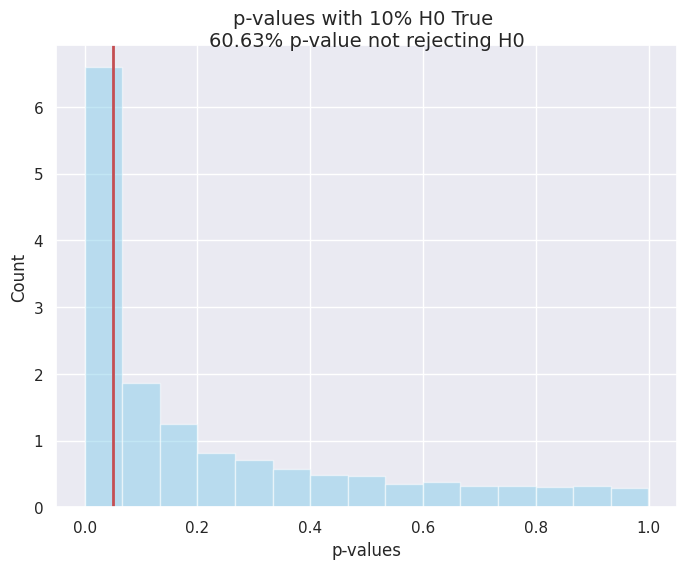

In [20]:
MC = 10000
rate = 10 / 100
pvalue = np.zeros(MC)

for m in range(MC):
    if m < MC * rate:  # p(H0|data) is 10%
        X = np.random.randn(100)
        Y = np.random.randn(100)
    else:
        X = np.random.randn(100) + 0.25  # expected mean 0.25
        Y = np.random.randn(100)         # expected mean 0
    _, pvalue[m] = ttest_ind(X, Y)

fig = plt.figure('p-values are not P(H0|data)', figsize=(8, 6))
plt.hist(pvalue, density=True, alpha=0.5, bins=15, color='skyblue')
plt.axvline(0.05, color='r', linestyle='-', linewidth=2, label='Threshold')
plt.title('p-values with 10% H0 True \n'+f"{np.mean(pvalue > 0.05) * 100:.2f}% p-value not rejecting H0", fontsize=14, y=0.98)
plt.xlabel('p-values')
plt.ylabel('Count')
plt.grid(True)

plt.show()